# Basic Usage
---
This notebook illustrates the basic usage to create incremental explanations with our incremental explainers.
For further or more specific information, we refer to the other notebooks, the documentation, and this article.

#### Import Modules
Import all modules necessary for this tutorial at once.

In [1]:
from river.metrics import Accuracy
from river.utils import Rolling
from river.ensemble import AdaptiveRandomForestClassifier

from river.datasets.synth import Agrawal
from river.datasets.synth import ConceptDriftStream

from ixai.explainer import IncrementalPFI
from ixai.visualization import FeatureImportancePlotter

#### Setup data stream
Initialize a concept drift data stream. The `river` package provides various data streams and utility functions. Here we create a synthetic concept drift data stream derived from the *agrawal* concepts (`classification_function=1` and `classification_function=2`).
The concept drift is centered at the middle of our data stream with a width of 10%.<br>

For our explanation methods we also need a list of all `feature_names` to be used in the model and later to be explained.

In [2]:
n_samples = 15_000
stream = Agrawal(classification_function=1, seed=42)
drift_stream = Agrawal(classification_function=2, seed=42)
stream = ConceptDriftStream(stream, drift_stream, position=int(n_samples * 0.5), width=int(n_samples * 0.1), seed=42)

feature_names = list([x_0 for x_0, _ in stream.take(1)][0].keys())
feature_names

['salary',
 'commission',
 'age',
 'elevel',
 'car',
 'zipcode',
 'hvalue',
 'hyears',
 'loan']

#### Setup model and loss function
Now we set up our incremental learning model. Since *agrawal* is a classification problem, we utilize a `AdaptiveRandomForestClassifier`.
We need to provide the explainer object a `model_function` and a `loss_function`. Both of these functions need to match. A loss function that compares class probabilities (e.g. CrossEntropy) does not work with a prediction function that only provides the class labels and no probability scores and vice versa.

For this example, we use the `predict_one` function of the river classifier and the `Accuracy()` metric. Note, that we could also use the `predict_proba_one` prediction function. This has a profound impact on the explanations.

In [3]:
model = AdaptiveRandomForestClassifier(n_models=5, max_depth=10, leaf_prediction='nba', seed=42)  # incremental learning model
model_function = model.predict_one  # model function for the explainer object

loss_metric = Accuracy()  # river metric that will be transformed into a suitable loss function
training_metric = Rolling(Accuracy(), window_size=1000)  # only for tracking the performance, not used for explanations

### Setup Explainers
For this basic example, we only illustrate how to create incremental explanations with the `IncrementalPFI` explainers. We further, do not go into the details of its implementations. For this, we strongly refer to this <a href="https://arxiv.org/abs/2209.01939" target="_blank">research paper</a>, the different tutorials, and the documentation.

Here we calculate iPFI 5 times (`n_inner_samples=5`) for each explanation step to get a more realistic estimate. Note that a larger value linearly increases the computation time of the explanations.

The `smoothing_alpha` is the most important parameter of our explanations. It controls how much emphasis is given to past observations and computed explanations. A higher value puts more emphasis on recent computations. A lower value distributes the emphasis onto more historic vales. The internal mechanism is an exponential smoothing. For further details, we again refer to the <a href="https://arxiv.org/abs/2209.01939" target="_blank">paper</a>.

In [4]:
incremental_pfi = IncrementalPFI(
    model_function=model_function,
    loss_function=loss_metric,
    feature_names=feature_names,
    smoothing_alpha=0.001,
    n_inner_samples=5
)

#### Setup Plotter
You can plot the importance values in form of a line plot with the `FeatureImportancePlotter` plotter. The plotter stores performance values and importance values. It can be controlled with multiple parameters.

In [5]:
pfi_plotter = FeatureImportancePlotter(feature_names=feature_names)

### Train and explain the models
---
The main training and explanation loop. Each observation is used to update the incremental explainer once. Notice that the explainer uses the current sample always before the model is updated with it.

In [6]:
for (n, (x_i, y_i)) in enumerate(stream, start=1):
    # predicting
    y_i_pred = model.predict_one(x_i)
    training_metric.update(y_true=y_i, y_pred=y_i_pred)

    # explaining
    inc_fi_pfi = incremental_pfi.explain_one(x_i, y_i)

    # visualize
    pfi_plotter.update_performance(training_metric.get(), facet_name='accuracy')
    pfi_plotter.update(inc_fi_pfi, facet_name='iPFI')

    # learning
    model.learn_one(x_i, y_i)

    if n % 2500 == 0:
        print(f"{n}: perf {training_metric.get()}\n"
              f"{n}: pfi  {incremental_pfi.importance_values}\n")

    if n >= n_samples:
        break

2500: perf 0.781
2500: pfi  {'zipcode': 0.005653812699196517, 'salary': 0.10659704399931307, 'elevel': 0.002530572844289024, 'commission': 0.15650258520964727, 'loan': 0.002948702240832644, 'car': -0.004209717521623402, 'hyears': 0.010079872002637245, 'hvalue': -0.0026752042504656344, 'age': 0.12671356724595317}

5000: perf 0.805
5000: pfi  {'zipcode': 0.009527818823875944, 'salary': 0.16339765843683288, 'elevel': 0.011302903989746536, 'commission': 0.14477145922525114, 'loan': 0.007744886118936555, 'car': 0.00046082719143098616, 'hyears': -0.003663071156000696, 'hvalue': 0.0099640272045319, 'age': 0.16761378775360494}

7500: perf 0.785
7500: pfi  {'zipcode': -0.0014443272537079594, 'salary': 0.2040761074112996, 'elevel': 0.004108467813082458, 'commission': 0.10153603911896743, 'loan': 0.004433323047370063, 'car': 0.002787979109571482, 'hyears': -0.002888626758682533, 'hvalue': 0.0046023372709909985, 'age': 0.17888777329112665}

10000: perf 0.885
10000: pfi  {'zipcode': -0.000694489612

### Visualize the explanations
Lastly, the explanations can be visualized. Notice how we can clearly see the concept drift induced by changing the classification function. The model performance significantly drops and quickly recovers, as the incremental model easily adapts. With these explanations we can directly identify what happens inside the model and can understand what features are important for the model at any given time.

At first, the model learns that `salary`, `commission` and `age` are important to discriminate between the classes of the data stream. For the classification function, only `salary` and `age` are important. However, `commission` is dependent on `salary`. Hence, the model picked up on that dependency and uses it internally, as all three features are important.

After the concept drift, the Random Forest model quickly reacts to the changes and restructures its decision rules. After the change only the independent `age` and `elevel` features are relevant for the classification problem.

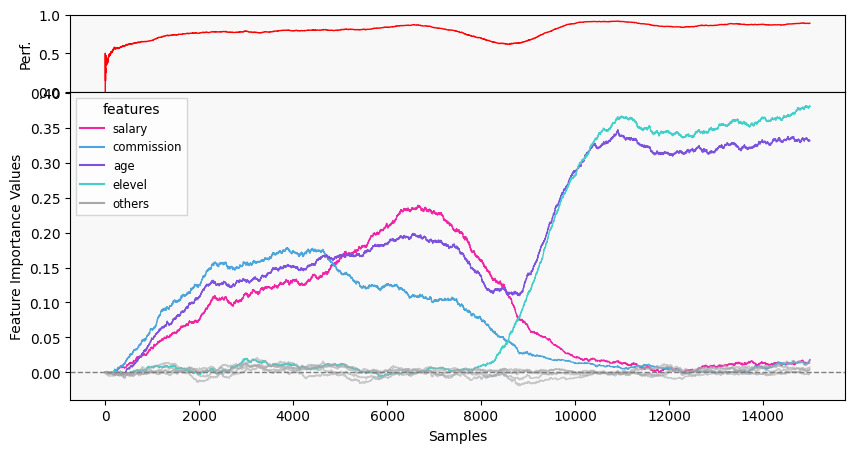

In [7]:
performance_kw = {
    "y_min": 0, "y_max": 1,
}

fi_kw = {
    "names_to_highlight": ["salary", "commission", "age", "elevel"],
    "legend_style": {
        "fontsize": "small", 'title': 'features', "ncol": 1,
        "loc": 'upper left', "bbox_to_anchor": (0, 1)}
}

pfi_plotter.plot(
    performance_kw=performance_kw,
    **fi_kw
)